#### Demo 04: View water column data

## Introduction

This Jupyter Notebook contains an introduction to viewing water column data using Ping.

## Here you will learn

- 

## Short version

At the end of the notebook you will find the important parts of this notebook, compiled into a single cell


## ---

### First: Import the necessary modules

In [1]:
%matplotlib widget
import os
from tqdm.auto import tqdm

import numpy as np

from matplotlib import pyplot as plt
from themachinethatgoesping.echosounders import index_functions
from themachinethatgoesping.echosounders import kongsbergall
import themachinethatgoesping as Ping


In [9]:
# define a list of folder(s) to search for raw data files
folders = []

#folders = ["../unittest_data/"]

folders.append("/home/data/turbeams/TURBEAMS_data_crunshing/campaigns/05_TURBEAMS_April_2023/Stations")
folders.append("/home/data/turbeams/TURBEAMS_data_crunshing/campaigns/05_TURBEAMS_April_2023/Transect")
# folders = [
#    '/home/data/test_data/alex_yolla/'
# ]
#folders = ["../unittest_data/"]

# find all .all/.wcd files and cache file positions
files = index_functions.find_files(folders, [".all","wcd"])
cache_files = index_functions.get_cache_file_paths(files)

# open all files and index
fm = kongsbergall.KongsbergAllFileHandler(files,cache_files)    
Ping.pingprocessing.core.clear_memory()

Found 288 files
indexing files ⢀ 99% :02s<00m:00s] [Found: 5130471 datagrams in 288 files (25571MB)]                                                 
Initializing navigation ⠁ 95% :04s<00m:00s] [140/144]                     
Initializing ping interface ⠠ 99% :07s<00m:00s] [Done]                                              


## Add ping calibration

  0%|          | 0/210675 [00:00<?, ?it/s]

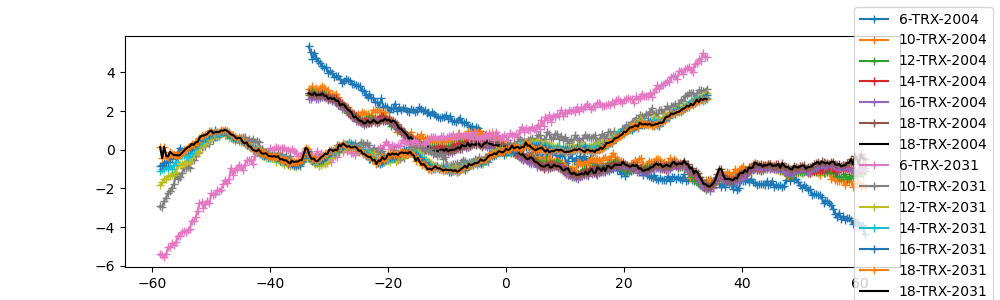

In [10]:
#load calibration
import pandas as pd
from collections import defaultdict
calib = {}
calib['TRX-2004'] = pd.read_excel('calibration/calib-TRX-2004.xlsx')
calib['TRX-2031'] = pd.read_excel('calibration/calib-TRX-2031.xlsx')
layer = 18


static_calib = defaultdict(Ping.echosounders.filetemplates.WaterColumnCalibration)

fig,ax = Ping.pingprocessing.core.create_figure('Calibration')
for k,d in calib.items():
    for plot_layer in [6,10,12,14,16,18]:
        ax.plot(d['water_angle'], d[plot_layer], label=f'{plot_layer}-{k}', marker='+')
        
    ax.plot(d['water_angle'], d[layer], label=f'{layer}-{k}', color='black')
    static_calib[k].set_offset_per_beamangle(d['water_angle'], -d[layer])
    
fig.legend()
fig.set_size_inches(10,3)

for ping in tqdm(fm.get_pings()):    
    channel_id = ping.get_channel_id()
    if True:
        ping.watercolumn.set_calibration(static_calib[channel_id])
    else:
        calib_data = calib[channel_id]
        sort_arg = np.argsort(ping.bottom.get_beam_crosstrack_angles())
        I = Ping.tools.vectorinterpolators.AkimaInterpolatorFF(
            ping.bottom.get_beam_crosstrack_angles()[sort_arg],
            ping.watercolumn.get_beam_crosstrack_angles()[sort_arg]
        )
        per_ping_calib = Ping.echosounders.filetemplates.WaterColumnCalibration()
        per_ping_calib.set_offset_per_beamangle(I(calib_data['angle']), -calib_data[layer])
        
        ping.watercolumn.set_calibration(per_ping_calib)

## Filter pings
Pings must contain watercolumn amplitudes to view watercolumn data


In [11]:
filtered_pings = Ping.pingprocessing.filter_pings.by_features(fm.get_pings(), ['watercolumn.av', 'bottom.xyz'], progress = True)

grouped_pings = Ping.pingprocessing.group_pings.dual_head(filtered_pings, progress = True)

pings_per_transducer = Ping.pingprocessing.split_pings.by_channel_id(filtered_pings, progress = True)

for k,v in pings_per_transducer.items():
    print(f'-{k: <10}: {len(v)}')

Filter pings by features:  34%|###4      | 72660/210675 [00:02<00:03, 36329.87it/s]

-TRX-2004  : 105221
-TRX-2031  : 105268


In [12]:
del fm 
Ping.pingprocessing.core.clear_memory()

## Create and view echograms

In [14]:
pss = Ping.echosounders.pingtools.PingSampleSelector()
pss.select_beam_range_by_angles(-3.5,3.5,1)

echodata = Ping.pingprocessing.watercolumn.echograms.EchoData.from_pings(
    pings_per_transducer['TRX-2004'][::20],
    pss = pss,
    wci_value = 'sv', 
    linear_mean = False)

 20%|##        | 1059/5262 [00:01<00:03, 1058.94it/s]

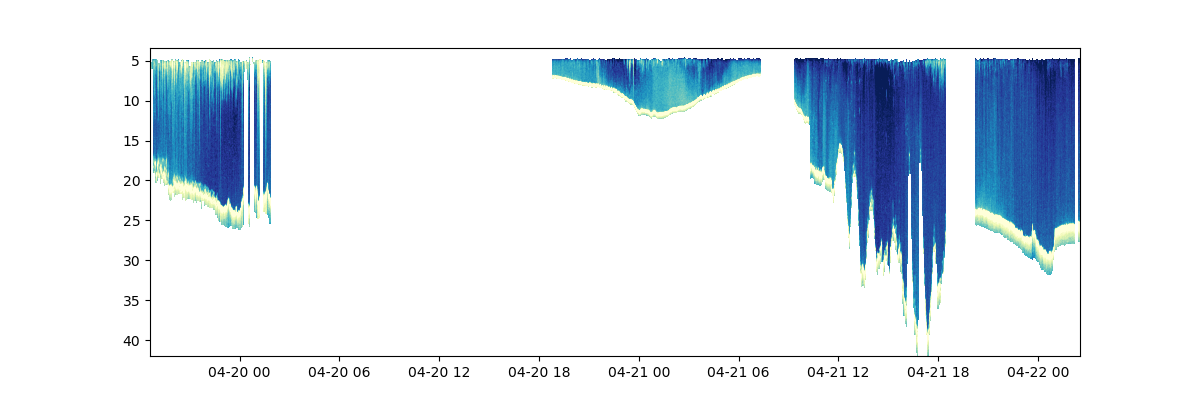

In [15]:

echodata.set_x_axis_ping_nr(max_steps=5000)
echodata.set_y_axis_depth()
echodata.set_x_axis_date_time(max_steps=5000)
image,extent = echodata.build_image()

fig,ax = Ping.pingprocessing.core.create_figure('echogram')
fig.set_size_inches(12,4)

ax.imshow(image.transpose(), extent=extent, cmap='YlGnBu_r', aspect='auto', vmin=-90, vmax=-50)

In [16]:
import matplotlib.dates as mdates
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xmin = mdates.num2date(xlim[0]).timestamp()
xmax = mdates.num2date(xlim[1]).timestamp()

echodata.set_x_axis_date_time(min_ping_time = xmin, max_ping_time = xmax, max_steps=5000)

image,extent = echodata.build_image()

ax.imshow(image.transpose(), extent=extent, cmap='YlGnBu_r', aspect='auto', vmin=-90, vmax=-50)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
xmin,xmax

(1682014688.209143, 1682063382.989147)

In [17]:
%%timeit -n1 -r1

import pickle
with open('echo.pkl','wb') as ofi:
    pickle.dump(echodata, ofi)

114 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [18]:
#%%timeit -n1 -r1

import pickle
echodata = pickle.load(open('echo.pkl','rb'))

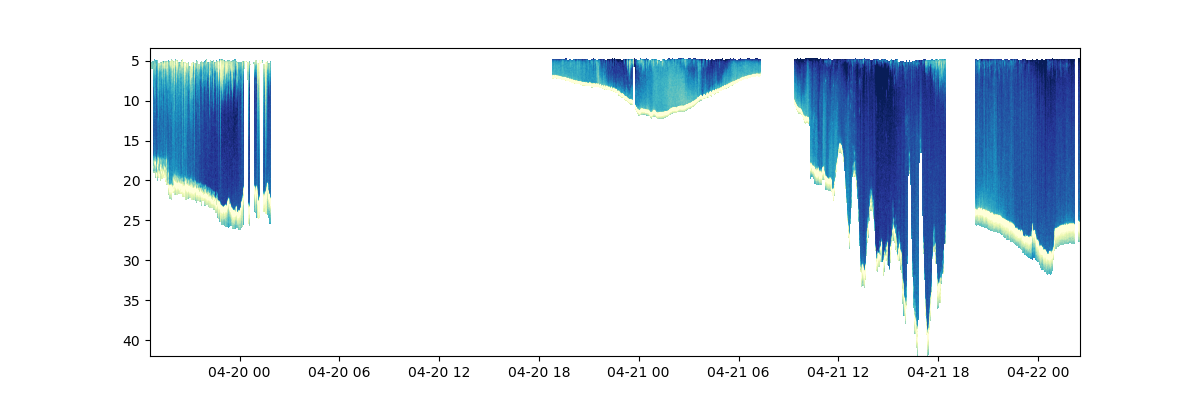

In [37]:
echodata.set_x_axis_date_time(max_steps=20000)
echodata.set_y_axis_depth()
image,extent =  echodata.build_image()

fig,ax = Ping.pingprocessing.core.create_figure('echogram')
fig.set_size_inches(12,4)

ax.imshow(image.transpose(), extent=extent, cmap='YlGnBu_r', aspect='auto', vmin=-90, vmax=-50)

## Plot pings

In [38]:
pss = Ping.echosounders.pingtools.PingSampleSelector()
pss.select_beam_range_by_angles(-90,90,1)

plotter = Ping.pingprocessing.widgets.WCIViewer(grouped_pings[::], ping_sample_selector = pss)

In [46]:
pn = plotter.w_index.value
Ping.pingprocessing.watercolumn.image.make_wci_stack(grouped_pings[pn:pn+10], 1024, progress=tqdm)

(array([[       nan,        nan,        nan, ...,        nan,        nan,
                nan],
        [       nan,        nan,        nan, ...,        nan,        nan,
                nan],
        [       nan,        nan,        nan, ...,        nan,        nan,
                nan],
        ...,
        [       nan,        nan,        nan, ..., -64.96491 , -68.81011 ,
         -69.313896],
        [       nan,        nan,        nan, ..., -69.96871 , -72.2439  ,
                nan],
        [       nan,        nan,        nan, ..., -72.2439  , -66.24769 ,
                nan]], dtype=float32),
 (-47.52739750441685, 48.290504041282084, 33.19767524298801, 4.15255711975918))

In [41]:
import ipywidgets
import matplotlib.dates as mdates

if 'cid' in globals():
    fig.canvas.mpl_disconnect(cid)
    del cid

output=ipywidgets.Output()

times, ping_numbers = [],[]
for pn,pg in enumerate(tqdm(grouped_pings)):
    ping = next(iter(pg.values()))
    times.append(ping.get_timestamp())
    ping_numbers.append(pn)

closest_ping = Ping.tools.vectorinterpolators.NearestInterpolatorDI(times, ping_numbers)
    

def onclick(event):
    with output:
        # print('%s click: button=%d, x=%d, y=%d, xdata=%f, ydata=%f' %
        #       ('double' if event.dblclick else 'single', event.button,
        #        event.x, event.y, event.xdata, event.ydata))
        
        if event.button == 1:
                time = mdates.num2date(event.xdata).timestamp()
                ping_number = closest_ping(time)
                # find closest time in grouped pings
                #print(time, closest_ping(time))
                plotter.w_index.value = ping_number
        else:
            if event.button == 3:
                xmin, xmax = ax.get_xlim()
                time1 = mdates.num2date(xmin).timestamp()
                time2 = mdates.num2date(xmax).timestamp()
                echodata.set_x_axis_date_time(max_steps=20000, min_ping_time = time1, max_ping_time = time2)
                image,extent =  echodata.build_image()
                ax.imshow(image.transpose(), extent=extent, cmap='YlGnBu_r', aspect='auto', vmin=-90, vmax=-50)
                e.set_x_axis_date_time(max_steps=20000, min_ping_time = time1, max_ping_time = time2)
                image,extent =  e.build_image()
                ax.imshow(image.transpose(), extent=extent, cmap='jet', aspect='auto', vmin=-90, vmax=-50)
                # ping_number1 = closest_ping(time1)
                # ping_number2 = closest_ping(time2)
                # plotter.w_index.value = ping_number11
                # plotter.w_stack.value = ping_number2-ping_number1
                
        
        

cid = fig.canvas.mpl_connect('button_press_event', onclick)
output

  0%|          | 0/105294 [00:00<?, ?it/s]

Output()

In [ ]:
help(echodata.set_x_axis_date_time)

In [34]:
from jupyter_ui_poll import ui_events
import ipywidgets

prg = tqdm('ping video')
plotter.stop_botton = ipywidgets.ToggleButton(description = 'loop controll', value = 0)
plotter.layout.children = (*plotter.layout.children, plotter.stop_botton)

plotter.stop_botton.value = 1
display(plotter.stop_botton)


plotter.w_index.value=0
while plotter.stop_botton.value == 1:
    plotter.stop_botton.button_style = 'success'
    di = int(plotter.w_stack.value/2)
    if di < 1: di = 1
    
    i = plotter.w_index.value + di
    if i >= len(plotter.imagebuilder.pings):
        i = 0
        
    plotter.w_index.value = i
    #ipywidgets.
    with ui_events() as ui_poll:
        ui_poll(10) # poll queued UI events including button
    prg.update()
    
plotter.stop_botton.button_style = ''
plotter.layout.children = list(plotter.layout.children[:-1])

  0%|          | 0/10 [00:00<?, ?it/s]

ToggleButton(value=True, description='loop controll')

In [ ]:
#load calibration
import pandas as pd
from collections import defaultdict
calib = {}
calib['TRX-2004'] = pd.read_excel('calibration/calib-TRX-2004.xlsx')
calib['TRX-2031'] = pd.read_excel('calibration/calib-TRX-2031.xlsx')
layer = 18


static_calib = defaultdict(Ping.echosounders.filetemplates.WaterColumnCalibration)

fig,ax = Ping.pingprocessing.core.create_figure('Calibration')
for k,d in calib.items():
    for plot_layer in [6,10,12,14,16,18]:
        ax.plot(d['water_angle'], d[plot_layer], label=f'{plot_layer}-{k}', marker='+')
        
    ax.plot(d['water_angle'], d[layer], label=f'{layer}-{k}', color='black')
    static_calib[k].set_offset_per_beamangle(d['water_angle'], -d[layer])
    
fig.legend()
fig.set_size_inches(10,3)

for ping in tqdm(filtered_pings):    
    channel_id = ping.get_channel_id()
    if True:
        ping.watercolumn.set_calibration(static_calib[channel_id])
    else:
        calib_data = calib[channel_id]
        sort_arg = np.argsort(ping.bottom.get_beam_crosstrack_angles())
        I = Ping.tools.vectorinterpolators.AkimaInterpolatorFF(
            ping.bottom.get_beam_crosstrack_angles()[sort_arg],
            ping.watercolumn.get_beam_crosstrack_angles()[sort_arg]
        )
        per_ping_calib = Ping.echosounders.filetemplates.WaterColumnCalibration()
        per_ping_calib.set_offset_per_beamangle(I(calib_data['angle']), -calib_data[layer])
        
        ping.watercolumn.set_calibration(per_ping_calib)

In [ ]:
print(c)